### A/B-testing

### Part 1: Splitting

In [1]:
import hashlib
import random 
from typing import Tuple, List

In [2]:
class InvalidWeightData(ValueError):
    def __init__(self, message):
        super().__init__(message)
        self.msgfmt = message

In [3]:
class Experiment:
    """Experiment class. Contains the logic for assigning users to groups."""

    def __init__(
        self,
        experiment_id: int,
        groups: Tuple[str] = ("A", "B"),
        group_weights: List[float] = None,
    ):
        self.experiment_id = experiment_id
        self.groups = groups
        self.group_weights = group_weights
        
        # Define the salt for experiment_id.
        # The salt should be deterministic and unique for each experiment_id.
        self.salt = str(experiment_id)

        # Define the group weights if they are not provided equaly distributed
        # Check input group weights. They must be non-negative and sum to 1.
        

        if self.group_weights:
            w = 0
            for wieght in group_weights:
                if wieght < 0:
                    raise InvalidWeightData("Wieght is negative")
                w += wieght
            if w != 1:
                    raise InvalidWeightData("Sum of weights not equal to 1")
                    
    def group(self, click_id: int) -> Tuple[int, str]:
        """Assigns a click to a group.

        Parameters
        ----------
        click_id: int :
            id of the click

        Returns
        -------
        Tuple[int, str] :
            group id and group name
        """
        # Assign the click to a group randomly based on the group weights
        # Return the group id and group name
        
        click_id = str(click_id)
        click_hash = hashlib.sha256(str(click_id+self.salt).encode('utf-8')).hexdigest()
        click_hash = int(click_hash, 16)
        print(click_hash)
        if self.group_weights:
            random.seed(click_hash)
            group_ids = range(len(self.groups))
            group_id = random.choices(group_ids, self.group_weights)[0]
            
        else:
            group_id = click_hash%len(self.groups)
            
        
        return group_id, self.groups[group_id]

In [4]:
ex = Experiment(5, ('A', 'B', 'C'), [0.5, 0.05, 0.45])

In [5]:
ex.group(2)

83065501960078139073241228247522869445681663391659423428962806080829970134377


(2, 'C')

### Part-2: Statistical test

In [6]:
from scipy import stats
import numpy as np

def cpc_sample(
    n_samples: int, conversion_rate: float, reward_avg: float, reward_std: float
) -> np.ndarray:
    """Sample data."""
    
    cvr = np.random.binomial(n=1, p=conversion_rate, size=n_samples)
    cpa = np.random.normal(loc=reward_avg, scale=reward_std, size=n_samples)
    
    return cvr*cpa

In [7]:
def t_test(cpc_a: np.ndarray, cpc_b: np.ndarray, alpha=0.05
) -> Tuple[bool, float]:
    """Perform t-test.

    Parameters
    ----------
    cpc_a: np.ndarray :
        first samples    
    cpc_b: np.ndarray :
        second samples
    alpha :
         (Default value = 0.05)

    Returns
    -------
    Tuple[bool, float] :
        True if difference is significant, False otherwise
        p-value
    """
    
    _, pvalue = stats.ttest_ind(cpc_a, cpc_b)
    accept = bool(pvalue<alpha)
    return (accept, pvalue)

In [8]:
cpc_a = cpc_sample(10, 0.5, 1, 1)
cpc_b = cpc_sample(10, 0.5, 1, 2)
t_test(cpc_a, cpc_b)

(False, 0.2492338803889851)

### Part-3: A/A-test

In [9]:
from tqdm import tqdm

In [10]:
def aa_test(
    n_simulations: int,
    n_samples: int,
    conversion_rate: float,
    reward_avg: float,
    reward_std: float,
    alpha: float = 0.05,
) -> float:
    """Do the A/A test (simulation)."""
    
    type_1_errors = np.zeros(n_simulations)
    p_values = np.zeros(n_simulations)
    for i in tqdm(range(n_simulations)):
        # Generate two cpc samples with the same conversion_rate, reward_avg, and reward_std
        # Check t-test and save type 1 error
        cpc_a = cpc_sample(n_samples, conversion_rate, reward_avg, reward_std)
        cpc_b = cpc_sample(n_samples, conversion_rate, reward_avg, reward_std)
        type_1_errors[i] = t_test(cpc_a, cpc_b, alpha)[0]
        p_values[i] = t_test(cpc_a, cpc_b, alpha)[1]
    # Calculate the type 1 errors rate
    type_1_errors_rate = sum(type_1_errors)/n_simulations
    return type_1_errors_rate, p_values
    #return type_1_errors_rate

In [11]:
type_1_errors_rate, p_values_aa = aa_test(1000, 10000, 0.5, 1, 0)

100%|██████████| 1000/1000 [00:02<00:00, 368.92it/s]


In [12]:
type_1_errors_rate

0.044

Text(3.799999999999997, 0.5, 'Counts')

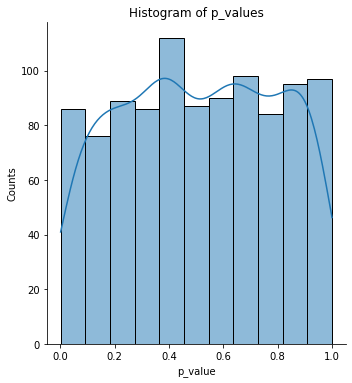

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.displot(x=p_values_aa, kde=True)
plt.title('Histogram of p_values')
plt.xlabel('p_value')
plt.ylabel('Counts')

### Part-4: A/B-test

* Ошибка 1 рода -> приняли гипотезу, а она не верная (чтобы определить проводим а/а-тест, где изначально нет различий => доля изменений,которые улавливаем и есть наша ошибка) - \alpha
* Ошибка 2 рода -> отвергли гипотезу, а отличия есть; проводим a/b-тест на изначально различных данных (распределениях); доля не отвергнутых гипотез и есть ошибка - \beta
* MDE (minimal detectable effect) — минимальный эффект, который мы можем поймать
* Мощностью теста (или чувствительностью) называют вероятность, с которой мы будем фиксировать нужный нам MDE (1 - β)
* Чем больше чувствительность теста, тем меньше ошибок будет совершаться и меньшие эффекты можно фиксировать (мощность  фиксируют на уровне 80-99%)

In [14]:
def ab_test(
    n_simulations: int,
    n_samples: int,
    conversion_rate: float,
    mde: float,
    reward_avg: float,
    reward_std: float,
    alpha: float = 0.05,
) -> float:
    """Do the A/B test (simulation)."""
    p_values = np.zeros(n_simulations)
    type_2_errors = np.zeros(n_simulations)
    for i in tqdm(range(n_simulations)):
        # Generate one cpc sample with the given conversion_rate, reward_avg, and reward_std
        # Generate another cpc sample with the given conversion_rate * (1 + mde), reward_avg, and reward_std
        # Check t-test and save type 2 error
        cpc_a = cpc_sample(n_samples, conversion_rate, reward_avg, reward_std)
        cpc_b = cpc_sample(n_samples, conversion_rate*(1+mde), reward_avg, reward_std)
        type_2_errors[i] = t_test(cpc_a, cpc_b, alpha)[0]
        p_values[i] = t_test(cpc_a, cpc_b, alpha)[1]


    # Calculate the type 2 errors rate
    type_2_errors_rate = 1 - sum(type_2_errors)/n_simulations

    return type_2_errors_rate, p_values
    #return type_2_errors_rate

In [15]:
type_2_errors_rate, p_values_ab = ab_test(n_simulations=1000, n_samples=1000, conversion_rate=0.5, mde=0.1, reward_avg= 1, reward_std=0)

100%|██████████| 1000/1000 [00:01<00:00, 912.18it/s]


In [16]:
type_2_errors_rate

0.375

Text(3.799999999999997, 0.5, 'Counts')

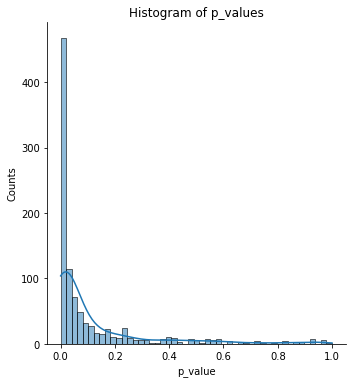

In [17]:
sns.displot(x=p_values_ab, kde=True)
plt.title('Histogram of p_values')
plt.xlabel('p_value')
plt.ylabel('Counts')

Функции распределения p-value при A/A и A/Б тестах:\
https://habr.com/ru/companies/X5Tech/articles/706388/ 

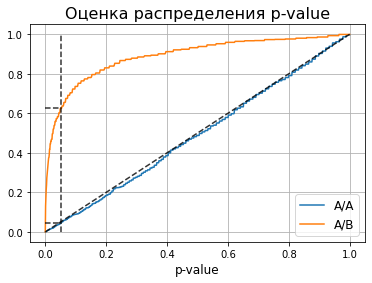

In [19]:
alpha=0.05
y_one = type_1_errors_rate
y_two = 1 - type_2_errors_rate
X = np.linspace(0, 1, 1000)
Y_aa = [np.mean(p_values_aa < x) for x in X]
Y_ab = [np.mean(p_values_ab < x) for x in X]

plt.plot(X, Y_aa, label='A/A')
plt.plot(X, Y_ab, label='A/B')
plt.plot([alpha, alpha], [0, 1], '--k', alpha=0.8)
plt.plot([0, alpha], [y_one, y_one], '--k', alpha=0.8)
plt.plot([0, alpha], [y_two, y_two], '--k', alpha=0.8)
plt.plot([0, 1], [0, 1], '--k', alpha=0.8)

plt.title('Оценка распределения p-value', size=16)
plt.xlabel('p-value', size=12)
plt.legend(fontsize=12)
plt.grid()
plt.show()

### Sample size, MDE
Напишем функцию для подбора размера выборки при заданных ошибках 1-го и 2-го рода

In [35]:
from typing import List, Tuple
import numpy as np
from scipy import stats


def select_sample_size(
    n_samples_grid: List[int],
    n_simulations: int,
    conversion_rate: float,
    mde: float,
    reward_avg: float,
    reward_std: float,
    alpha: float = 0.05,
    beta: float = 0.2,
) -> Tuple[int, float, float]:
    """Select sample size."""
    for n_samples in n_samples_grid:
        type_1_error = aa_test(n_simulations, n_samples, conversion_rate, reward_avg, reward_std, alpha)
        type_2_error = ab_test(n_simulations, n_samples, conversion_rate, mde, reward_avg, reward_std, alpha)
        print(type_1_error)
        print(type_2_error)
        if type_1_error < alpha and type_2_error < beta:
            return n_samples, type_1_error, type_2_error
    
    raise RuntimeError(
        "Can't find sample size. "
        f"Last sample size: {n_samples}, "
        f"last type 1 error: {type_1_error}, "
        f"last type 2 error: {type_2_error}"
        "Make sure that the grid is big enough."
    )


def select_mde(
    n_samples: int,
    n_simulations: int,
    conversion_rate: float,
    mde_grid: List[float],
    reward_avg: float,
    reward_std: float,
    alpha: float = 0.05,
    beta: float = 0.2,
) -> Tuple[float, float]:
    """Select MDE."""
    for mde in mde_grid:
        type_2_error = ab_test(n_simulations, n_samples, conversion_rate, mde, reward_avg, reward_std, alpha)
        if type_2_error<beta:
            return mde, type_2_error
    
    raise RuntimeError(
        "Can't find MDE. "
        f"Last MDE: {mde}, "
        f"last type 2 error: {type_2_error}. "
        "Make sure that the grid is big enough."
    )

In [34]:
select_sample_size(n_samples_grid=[100, 500, 1000, 5000, 10000, 50000], n_simulations=1000, conversion_rate=0.5, mde=0.15, reward_avg= 1, reward_std=0)

100%|██████████| 1000/1000 [00:00<00:00, 1594.07it/s]


0.052
0.8089999999999999


100%|██████████| 1000/1000 [00:00<00:00, 1856.28it/s]


0.055
0.32599999999999996


100%|██████████| 1000/1000 [00:00<00:00, 1609.94it/s]


0.052
0.07099999999999995


100%|██████████| 1000/1000 [00:01<00:00, 725.12it/s]

0.045
0.0


(5000, 0.045, 0.0)

In [36]:
select_mde(n_samples = 5000, n_simulations=1000, conversion_rate=0.5, mde_grid=[0.01, 0.1, 0.15, 0.2], reward_avg= 1, reward_std=0)

100%|██████████| 1000/1000 [00:01<00:00, 856.91it/s]


(0.1, 0.0)

### Formula for Sample size, MDE
(для нормально распределенных данных)


$$ n > \frac{[z_{\alpha/2} + z_{beta}]^2  2\sigma^2}{MDE^2} $$

In [56]:
import math
import numpy as np
from scipy import stats



def calculate_sample_size(
    reward_avg: float, reward_std: float, mde: float, alpha: float, beta: float
) -> int:
    """Calculate sample size.

    Parameters
    ----------
    reward_avg: float :
        average reward
    reward_std: float :
        standard deviation of reward
    mde: float :
        minimum detectable effect
    alpha: float :
        significance level
    beta: float :
        type 2 error probability

    Returns
    -------
    int :
        sample size

    """
    assert mde > 0, "mde should be greater than 0"

    z_alpha = stats.norm.ppf(1-alpha/2)
    z_beta = stats.norm.ppf(1-beta)
    sample_size = (z_alpha+z_beta)**2*2*reward_std**2/(reward_avg*mde)**2
    return math.ceil(sample_size)

In [57]:
def calculate_mde(
    reward_std: float, sample_size: int, alpha: float, beta: float
) -> float:
    """Calculate minimal detectable effect.

    Parameters
    ----------
    reward_avg: float :
        average reward
    reward_std: float :
        standard deviation of reward
    sample_size: int :
        sample size
    alpha: float :
        significance level
    beta: float :
        type 2 error probability

    Returns
    -------
    float :
        minimal detectable effect

    """
    z_alpha = stats.norm.ppf(1-alpha/2)
    z_beta = stats.norm.ppf(1-beta)
    mde = (z_alpha+z_beta)*math.sqrt(2)*reward_std/(math.sqrt(sample_size))

    return mde

In [69]:
calculate_sample_size(reward_avg=5, reward_std=1, mde=0.1, alpha=0.05, beta=0.2)

63

In [70]:
calculate_mde(reward_std=0.1, sample_size=63, alpha=0.05, beta=0.2)

0.04991700964775749